In [1]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import glob
import shutil
import os

In [2]:
def get_center(inputfilename):
    file = fits.open(inputfilename)
    #WCS info from header
    CRVAL1 = file[1].header['CRVAL1']
    CRVAL2 = file[1].header['CRVAL2']
    CRPIX1 = file[1].header['CRPIX1']
    CRPIX2 = file[1].header['CRPIX2']
    CD1_1 = file[1].header['CD1_1']
    CD1_2 = file[1].header['CD1_2']
    CD2_1 = file[1].header['CD2_1']
    CD2_2 = file[1].header['CD2_2']
    
    A = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
    A_inv = np.linalg.inv(A)
    B = np.array([[CRVAL1],[CRVAL2]])
    r0 = np.array([[CRPIX1],[CRPIX2]])
    
    def coo_pixtosky(r):
        return np.matmul(A, r-r0) + B
    
    def coo_skytopix(r_sky):
        return np.matmul(A_inv, r_sky - B) + r0
    
    #Target location info
    RA_TARG = file[0].header['RA_TARG'] 
    DEC_TARG = file[0].header['DEC_TARG']
    r_sky_TARG = np.array([[RA_TARG], [DEC_TARG]])
    X_TARG, Y_TARG = int(coo_skytopix(r_sky_TARG)[0]), int(coo_skytopix(r_sky_TARG)[1])
    
    data = file[1].data
    
    s = 100
    max_i = 0
    max_j = 0
    maxval = 0
    for i in range(Y_TARG-s, Y_TARG+s+1):
        for j in range(X_TARG-s, X_TARG+s+1):
            if data[i][j] > maxval:
                maxval = data[i][j]
                max_i = i
                max_j = j 
    r = 50
    total_flux = 0
    i_integral = 0
    j_integral = 0
    for i in range(max_i-r, max_i+r+1):
        for j in range(max_j-r, max_j+r+1):
            total_flux += data[i][j]
            i_integral += i*data[i][j]
            j_integral += j*data[i][j]
    
    i_center = i_integral/total_flux
    j_center = j_integral/total_flux
    
    X_center = j_center +1
    Y_center = i_center +1
    r_center = np.array([[X_center], [Y_center]])
    

    return (X_center), (Y_center)

In [3]:
path = '/Users/ha/Makani_Project/DrizzlePac'
lst_raw = glob.glob(path + '/data/*/*/*raw.fits')
dark_lst = glob.glob(path + '/darks/HST/*/*raw.fits')

Function to create an average dark from archived data knowing a upper temperature

In [4]:
def avgdark_archived(dark_lst, upper_temp, upper_year = 2022, lower_year = 2011):
    w_data = np.zeros((1024,1024))
    total_time = 0
    num_combined = 0
    if upper_temp > 25.0:
        print('upper_temp >= 25.0')
    
    else:
        if upper_temp == 25.0:
            for item in dark_lst:
                file = fits.open(item)
    
                exptime = file[0].header['EXPTIME']
                temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
                year = int(file[0].header['DATE'][:4])
                data = file[1].data
 
                if temp >= 0.0 and temp <= upper_temp and year >= lower_year and year != 2019 and year != 2020:
                    w_data += data
                    total_time += exptime
                    num_combined += 1
        else:
            for item in dark_lst:
                file = fits.open(item)
    
                exptime = file[0].header['EXPTIME']
                temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
                year = int(file[0].header['DATE'][:4])
                data = file[1].data
                
                if temp >= 0.0 and temp <= upper_temp and year >= lower_year and year <= upper_year:
                    w_data += data
                    total_time += exptime
                    num_combined += 1
        
        w_data_cps = w_data / total_time
    
        avg_dark_Primary = fits.PrimaryHDU()
        avg_dark_SCI = fits.ImageHDU(w_data_cps)
        avg_dark_hdul = fits.HDUList([avg_dark_Primary, avg_dark_SCI])
        avg_dark_hdul.writeto('refdark_archived_uptemp'+ str(upper_temp)+ '_' +
                              str(lower_year)+ str(upper_year)+'.fits', overwrite = True)
    print('num_combined =', num_combined)

In [5]:
avgdark_archived(dark_lst, 25, 2022, 2022)
avgdark_archived(dark_lst, 24, 2022, 2022)
avgdark_archived(dark_lst, 23, 2022, 2022)
avgdark_archived(dark_lst, 24)
avgdark_archived(dark_lst, 23)
avgdark_archived(dark_lst, 22)
avgdark_archived(dark_lst, 21)
avgdark_archived(dark_lst, 22, 2022, 2022)

num_combined = 11
num_combined = 9
num_combined = 6
num_combined = 243
num_combined = 207
num_combined = 158
num_combined = 110
num_combined = 3


Flag out the galaxy from each frame ( real data )

In [6]:
%%time
#dark_file = fits.open('avg_dark_archived_uppertemp24.fits')
total_exptime = 0

for i in range(len(lst_raw)):
    flaged_table = np.ones((1024,1024))
    flaged_subtracted = np.zeros((1024, 1024))
    
    filename = lst_raw[i]
    rawfile = fits.open(filename)
    rawdata = rawfile[1].data
    exptime = rawfile[0].header['EXPTIME']
    
    x_center, y_center = get_center(filename)
    if np.isnan(x_center) or np.isnan(y_center):
        continue
    x_center, y_center = int(x_center), int(y_center)    
    
    #flag_table; flag_subtracted table
    flaged_subtracted = fits.open(filename)[1].data
    
    e = 25
    for i in range(y_center -e, y_center + e):
        for j in range(x_center - e, x_center + e):
            flaged_table[i][j] = 0.0
            flaged_subtracted[i][j] = 0

            
    #create a flaged file
    Primary = rawfile['Primary']
    SCI = fits.ImageHDU(rawdata, name = 'SCI', header = rawfile['SCI'].header)
    FLAG = fits.ImageHDU(flaged_table, name = 'FLAG')
    FLAG_subtracted = fits.ImageHDU(flaged_subtracted, name = 'FS')
    hdul = fits.HDUList([Primary, SCI, FLAG, FLAG_subtracted])
    hdul.writeto(filename[-18:-9] + '_flaged.fits', overwrite = True)
    
    
    #create a subtracted file
    #dark_frame = dark_file[0].data * exptime
    #new_data = rawdata - dark_frame
    
    #subtracted_SCI = fits.ImageHDU(new_data, name = 'SCI', header = rawfile['SCI'].header)
    #subtracted_hdul = fits.HDUList([Primary, subtracted_SCI, FLAG])
    #subtracted_hdul.writeto(filename[-18:-9] + '_subtracted_24.fits', overwrite = True)
    

/Users/ha/.conda/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/Users/ha/.conda/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars


CPU times: user 5.25 s, sys: 1.48 s, total: 6.73 s
Wall time: 9.19 s


In [7]:
directory_name = 'flaged'
parent_path = '/Users/ha/Makani_Project/DrizzlePac/Testxviii'
path = os.path.join(parent_path, directory_name)
os.makedirs(path)

In [9]:
old_flaged_lst = glob.glob('*_flaged.fits')
for files_path in old_flaged_lst:
    #print(files_path[:22])
    shutil.move(files_path, path)

Combine all the flaged file to create a new dark frame

In [10]:
%%time
flaged_lst =  glob.glob('flaged/*_flaged.fits')
sumdata_1subtracted = np.zeros((1024,1024))
exptime_table = np.zeros((1024,1024))
for filename in flaged_lst:
        file = fits.open(filename)
        data = file[1].data
        flaged_table = file['FLAG'].data
        flaged_subtracted = file['FS'].data
        exptime = file[0].header['EXPTIME']

        exptime_table += exptime * flaged_table
        sumdata_1subtracted += flaged_subtracted
        #print(file[0].header['DATE'])
for i in range(0, 1024):
    for j in range(0, 1024):
        sumdata_1subtracted[i][j] /= exptime_table[i][j]

Primary = fits.PrimaryHDU()
SCI = fits.ImageHDU(sumdata_1subtracted, name = 'SCI')
hdul = fits.HDUList([Primary, SCI])
hdul.writeto('avg_dark_summed_data.fits', overwrite = True)

CPU times: user 897 ms, sys: 293 ms, total: 1.19 s
Wall time: 2.73 s


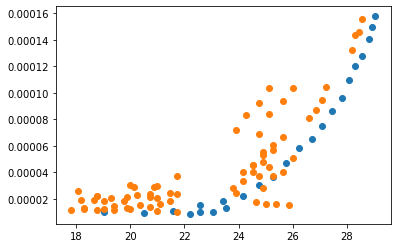

In [12]:
arch_temp = []
arch_darks = []
for item in dark_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE'][:4])
    data_ps = file[1].data/ exptime
    
    if year >= 2022 and temp >= 0.0:
        arch_temp.append(temp)
        sample = data_ps[471: 822, 471:822]
        darks = sum(sum(sample)) / (len(sample) * len(sample[0]))
        arch_darks.append(darks)
        
        
data_temp = []
data_darks = []
for item in flaged_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE'][:4])
    data_ps = file[1].data/ exptime
    
    data_temp.append(temp)
    sample = data_ps[471:822 , 471:822]
    darks = sum(sum(sample)) /( (len(sample) * len(sample[0])) - (2*e)**2)
    data_darks.append(darks)
    
plt.plot(arch_temp, arch_darks, 'o')
plt.plot(data_temp, data_darks, 'o')

In [ ]:
%%time
flaged_lst = glob.glob('*_flaged.fits')
sumdata_1subtracted = np.zeros((1024,1024))
exptime_table = np.zeros((1024,1024))
idx = 0
for filename in flaged_lst:
        file = fits.open(filename)
        data = file[1].data
        flaged_table = file['FLAG'].data
        flaged_subtracted = file['FS'].data
        exptime = file[0].header['EXPTIME']
        temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
        
        if temp > 23.0:
            continue
        idx += 1
        exptime_table += exptime * flaged_table
        sumdata_1subtracted += flaged_subtracted
        #print(file[0].header['DATE'])
for i in range(0, 1024):
    for j in range(0, 1024):
        sumdata_1subtracted[i][j] /= exptime_table[i][j]

print(idx)
Primary = fits.PrimaryHDU()
SCI = fits.ImageHDU(sumdata_1subtracted, name = 'SCI')
hdul = fits.HDUList([Primary, SCI])
hdul.writeto('avg_dark_summed_data_uptemp23.fits', overwrite = True)

In [ ]:
ref_dark = fits.open('refdark_archived_uptemp25_20222022.fits')
real_dark = fits.open('avg_dark_summed_data_uptemp25.fits')

ref_dark_data = ref_dark[1].data
real_dark_data = real_dark[1].data

data = real_dark_data - ref_dark_data
Primary = fits.PrimaryHDU(data)
hdul = fits.HDUList([Primary])
hdul.writeto('real_minus_ref_uptemp25_2022.fits', overwrite = True)

In [ ]:
ref_dark = fits.open('refdark_archived_uptemp24_20222022.fits')
real_dark = fits.open('avg_dark_summed_data_uptemp24.fits')

ref_dark_data = ref_dark[1].data
real_dark_data = real_dark[1].data

data = real_dark_data - ref_dark_data
Primary = fits.PrimaryHDU(data)
hdul = fits.HDUList([Primary])
hdul.writeto('real_minus_ref_uptemp24_2022.fits', overwrite = True)

In [ ]:
ref_dark = fits.open('refdark_archived_uptemp23_20222022.fits')
real_dark = fits.open('avg_dark_summed_data_uptemp23.fits')

ref_dark_data = ref_dark[1].data
real_dark_data = real_dark[1].data

data = real_dark_data - ref_dark_data
Primary = fits.PrimaryHDU(data)
hdul = fits.HDUList([Primary])
hdul.writeto('real_minus_ref_uptemp23_2022.fits', overwrite = True)

In [ ]:
real_data = fits.open('jec401noq_flaged.fits')
real_dark = fits.open('avg_dark_summed_data_uptemp24.fits')

temp = (real_data[1].header['MDECODT1'] + real_data[1].header['MDECODT2']) /2 
exptime = real_data[0].header['EXPTIME']
real_data = real_data[1].data
real_dark_data = real_dark[1].data

data = real_data - real_dark_data * exptime
Primary = fits.PrimaryHDU(data)
hdul = fits.HDUList([Primary])
hdul.writeto('abc_test.fits', overwrite = True)